# Setting up Colab GPU

This notebook is run on Colab GPU.

In [1]:
!git clone https://github.com/liuzhimei/M2_coursework.git
%cd M2_coursework

fatal: destination path 'M2_coursework' already exists and is not an empty directory.
/content/M2_coursework


In [2]:
!nvidia-smi --gpu-reset
!nvidia-smi

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.
Tue Mar 25 22:48:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|===================================

# Hyperparameter Search

In [3]:
import h5py
import torch
import itertools
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torch.utils.data import DataLoader, TensorDataset
from lora.lora_skeleton import LoRALinear, process_sequences
from src.preprocessor import preprocess_time_series, preprocess_all_time_series, tokenize_sequence
from src.qwen import load_qwen

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
with h5py.File("data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

## Define the training function

In [5]:
def train_model(model, tokenizer, train_texts, val_texts, learning_rate, lora_rank, max_ctx_length=512, epochs=5):
    # Apply LoRA
    for layer in model.model.layers:
        layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
        layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

    # Prepare optimizer
    optimizer = torch.optim.Adam(
        (p for p in model.parameters() if p.requires_grad), lr=learning_rate
    )


    train_input_ids = process_sequences(
        train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
    )
    val_input_ids = process_sequences(
        val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
    )

    # Prepare dataset
    train_dataset = TensorDataset(train_input_ids)
    val_dataset = TensorDataset(val_input_ids)

    batch_size = 4

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    accelerator = Accelerator()
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    train_losses = []
    val_losses = []

    model.train()
    steps = 0

    for epoch in range(epochs):
        total_train_loss = 0

        for (batch,) in tqdm(train_loader, desc=f"Training | Current step: {steps}"):
            torch.cuda.empty_cache()

            optimizer.zero_grad()
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()

            total_train_loss += loss.item()
            steps += 1

        # Average training loss per epoch
        train_losses.append(total_train_loss / len(train_loader.dataset))

        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for (batch,) in tqdm(val_loader, desc=f"Validating | Current step {steps}"):
                torch.cuda.empty_cache()
                outputs = model(batch, labels=batch)
                loss = outputs.loss
                total_val_loss += loss.item()

        # Average validation loss per epoch
        val_losses.append(total_val_loss / len(val_loader.dataset))

        print(
            f"LR: {learning_rate}, Rank: {lora_rank}, Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}"
        )

        model.train()

    return train_losses, val_losses

## Define the functions to measure prediction performances

In [6]:
def decode_time_series(generated_text, alpha=0.5, max_time_steps=20):
    """
    Decodes a generated time-series string of texts back into numerical data.

    Args:
        generated_text (str): Preprocessed string in LLMTIME format. e.g. ;6.398,1.204;6.676,1.310;6.891,1.446
        alpha (float): Scaling factor used during preprocessing (default is 0.5).
        max_time_steps (int): Maximum number of time steps to decode (default is 20).

    Returns:
        np.ndarray: Decoded time-series data of shape (T, 2).
    """
    # Remove leading semicolon if it exists
    generated_text = generated_text.lstrip(";")

    # Split the string into time steps and filter out any empty strings
    time_steps = [step for step in generated_text.split(";") if step]

    # Convert each pair of values back to float and reverse scaling
    data = []
    for i, step in enumerate(time_steps):
        if i >= max_time_steps:  # Stop after decoding max_time_steps
            break

        # Check if the step is in the correct format (i.e., contains exactly two values separated by a comma)
        if len(step.split(",")) == 2:
            try:
                prey, predator = map(float, step.split(","))
                data.append([prey * alpha, predator * alpha])
            except ValueError:
                print(f"Skipping invalid data (non-float values): {step}")
        else:
            print(f"Skipping malformed data: {step}")

    return np.array(data, dtype=np.float32)

In [7]:
def plot_predictions(model, tokenizer, learning_rate, lora_rank):
    plt.figure(figsize=(15, 6))

    accelerator = Accelerator()
    device = accelerator.device

    model.to(device)
    model.eval()

    for system_id in tqdm(range(2), desc="System"):
        prey = trajectories[system_id, :, 0] # a list of 100 points for population of prey
        predator = trajectories[system_id, :, 1] # a list of 100 points for population of predator

        raw_data = np.column_stack((prey[:80], predator[:80])) # only stack the first 80 time steps (shape: (80,2))

        preprocessed_text = preprocess_time_series(raw_data) # apply LLMTIME scheme to convert raw data to texts

        tokenized_input = tokenize_sequence(preprocessed_text)  # use Qwen2.5 to tokenize the text (looks like [17, 13, ...])

        # Generate predictions (repeat for stochastic models to get variance)
        num_samples = 10  # Number of samples to estimate uncertainty
        num_tokens = 350 # predict 20 time steps need many tokens (for decimal=3)
        preds = []

        for _ in range(num_samples):
            input_tensor = torch.tensor(tokenized_input, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

            # Autoregressive prediction for next num_token number of tokens
            generated_tokens = []
            for _ in range(num_tokens):
                with torch.no_grad():
                    output = model(input_tensor)

                    # Define temperature for randomness (variability) to the autoregressive predictions
                    temperature = 1.0  # You can experiment with higher values (1.0) or lower (0.5) for more randomness
                    logits = output.logits[:, -1, :] / temperature  # Adjust logits with temperature
                    probs = torch.nn.functional.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)  # Sample from the distribution

                    generated_tokens.append(next_token.item())

                    # Append predicted token to input for next step
                    input_tensor = torch.cat([input_tensor, next_token], dim=1) # final form: tensor([[17, 18, 13, ...]])

            # Decode generated tokens back to time series data
            print(f"generated tokens: {generated_tokens}")
            generated_text = tokenizer.decode(generated_tokens)
            print(f"generated text: {generated_text}")

            generated_series = decode_time_series(generated_text)  # Convert texts back to numerical series and truncate the series at 100 time step
            # print(f"generated time series: {generated_series}")

            # Only add if the shape is correct and no NaNs are present
            if generated_series is not None and generated_series.shape == (20, 2) and not np.isnan(generated_series).any():
                preds.append(generated_series)
            else:
                print(f"Skipping invalid sample with shape: {generated_series.shape}")


        preds = np.array(preds)  # Shape: (num_samples, T=20, 2)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)

        # Calculate the MSE for each system
        prey_mse = np.mean((mean_pred[:, 0] - prey[80:]) ** 2)
        predator_mse = np.mean((mean_pred[:, 1] - predator[80:]) ** 2)
        total_mse = prey_mse + predator_mse
        print(f"The MSE for system {system_id + 1} is: {total_mse}")

        # Plot true series
        plt.subplot(1, 2, system_id + 1)
        plt.plot(time_points, prey, label=f'True prey population', color='red', linewidth=2)
        plt.plot(time_points, predator, label=f'True predator population', color='blue', linewidth=2)

        # Plot predicted mean with dashed line
        plt.plot(time_points[80:], mean_pred[:, 0], label='Predicted mean prey population', color='red', linestyle='--')
        plt.plot(time_points[80:], mean_pred[:, 1], label='Predicted mean predator population', color='blue', linestyle='--')

        # Plot shaded area for 1 standard deviation
        plt.fill_between(time_points[80:],
                        mean_pred[:, 0] - std_pred[:, 0],
                        mean_pred[:, 0] + std_pred[:, 0],
                        color='red', alpha=0.2, label='±1 Std (Prey)')

        plt.fill_between(time_points[80:],
                 mean_pred[:, 1] - std_pred[:, 1],
                 mean_pred[:, 1] + std_pred[:, 1],
                 color='blue', alpha=0.2, label='±1 Std (Predator)')


        plt.title(f'System {system_id + 1} (with learning rate: {learning_rate}, lora rank: {lora_rank}) (MSE: {total_mse:.4f})')
        plt.xlabel('Prey')
        plt.ylabel('Predator')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

## Hyperparameter search and plot predictions


>>> Training with learning rate: 1e-05, LoRA rank: 2


Training | Current step: 0: 100%|██████████| 903/903 [04:35<00:00,  3.28it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  7.05it/s]


LR: 1e-05, Rank: 2, Epoch 1/5 | Train Loss: 0.4153 | Val Loss: 0.2223


Training | Current step: 903: 100%|██████████| 903/903 [04:35<00:00,  3.28it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  7.06it/s]


LR: 1e-05, Rank: 2, Epoch 2/5 | Train Loss: 0.2341 | Val Loss: 0.2055


Training | Current step: 1806: 100%|██████████| 903/903 [04:35<00:00,  3.28it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.04it/s]


LR: 1e-05, Rank: 2, Epoch 3/5 | Train Loss: 0.2203 | Val Loss: 0.1950


Training | Current step: 2709: 100%|██████████| 903/903 [04:35<00:00,  3.28it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.04it/s]


LR: 1e-05, Rank: 2, Epoch 4/5 | Train Loss: 0.2083 | Val Loss: 0.1859


Training | Current step: 3612: 100%|██████████| 903/903 [04:35<00:00,  3.28it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  7.03it/s]


LR: 1e-05, Rank: 2, Epoch 5/5 | Train Loss: 0.1989 | Val Loss: 0.1788


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 20, 13, 15, 17, 23, 11, 15, 13, 24, 15, 15, 26, 20, 13, 18, 19, 22, 11, 16, 13, 15, 22, 20, 26, 20, 13, 20, 24, 20, 11, 16, 13, 17, 20, 17, 26, 20, 13, 21, 20, 22, 11, 16, 13, 18, 22, 21, 26, 20, 13, 20, 24, 18, 11, 16, 13, 18, 24, 24, 26, 20, 13, 18, 22, 18, 11, 16, 13, 19, 15, 15, 26, 19, 13, 24, 19, 23, 11, 16, 13, 19, 16, 23, 26, 19, 13, 21, 16, 17, 11, 16, 13, 19, 20, 18, 26, 19, 13, 16, 20, 24, 11, 16, 13, 19, 21, 18, 26, 18, 13, 23, 20, 23, 11, 16, 13, 19, 22, 17, 26, 18, 13, 22, 23, 22, 11, 16, 13, 19, 21, 19, 26, 18, 13, 22, 22, 17, 11, 16, 13, 19, 16, 16, 26, 18, 13, 23, 16, 24, 11, 16, 13, 18, 17, 21, 26, 18, 13, 24, 22, 15, 11, 16, 13, 17, 18, 17, 26, 19, 13, 16, 18, 22, 11, 16, 13, 16, 20, 24, 26, 19, 13, 18, 16, 17, 11, 16, 13, 16, 16, 18, 26, 19, 13, 20, 16, 18, 11, 16, 13, 15, 22, 23, 26, 19, 13, 22, 17, 18, 11, 16, 13, 15, 19, 16, 26, 19, 13, 24, 15, 21, 11, 16, 13, 15, 16, 16, 26, 20, 13, 15, 20, 17, 11, 15, 13, 24, 23, 19, 26, 20, 13, 16, 16, 2

System:  50%|█████     | 1/2 [04:46<04:46, 286.25s/it]

generated tokens: [26, 20, 13, 15, 15, 20, 11, 15, 13, 23, 22, 17, 26, 20, 13, 17, 22, 17, 11, 15, 13, 24, 15, 16, 26, 20, 13, 19, 19, 17, 11, 15, 13, 24, 19, 19, 26, 20, 13, 19, 19, 23, 11, 16, 13, 15, 18, 23, 26, 20, 13, 16, 22, 16, 11, 16, 13, 16, 18, 24, 26, 19, 13, 21, 16, 24, 11, 16, 13, 17, 18, 20, 26, 19, 13, 15, 23, 22, 11, 16, 13, 17, 23, 19, 26, 18, 13, 22, 18, 19, 11, 16, 13, 18, 15, 22, 26, 18, 13, 19, 18, 24, 11, 16, 13, 18, 16, 17, 26, 18, 13, 18, 16, 17, 11, 16, 13, 17, 24, 18, 26, 18, 13, 18, 15, 21, 11, 16, 13, 17, 17, 23, 26, 18, 13, 18, 20, 16, 11, 16, 13, 16, 18, 22, 26, 18, 13, 19, 18, 23, 11, 16, 13, 15, 17, 23, 26, 18, 13, 20, 23, 15, 11, 15, 13, 24, 17, 19, 26, 18, 13, 22, 19, 15, 11, 15, 13, 23, 20, 22, 26, 18, 13, 24, 17, 22, 11, 15, 13, 23, 18, 21, 26, 19, 13, 16, 21, 20, 11, 15, 13, 23, 18, 21, 26, 19, 13, 18, 24, 16, 11, 15, 13, 23, 19, 22, 26, 19, 13, 21, 20, 22, 11, 15, 13, 23, 23, 15, 26, 20, 13, 15, 15, 17, 11, 15, 13, 24, 16, 24, 26, 20, 13, 16, 22, 1

System: 100%|██████████| 2/2 [09:32<00:00, 286.22s/it]

generated tokens: [26, 19, 13, 21, 22, 20, 11, 17, 13, 18, 19, 22, 26, 19, 13, 20, 24, 21, 11, 17, 13, 18, 17, 22, 26, 19, 13, 21, 16, 19, 11, 17, 13, 17, 24, 20, 26, 19, 13, 21, 20, 20, 11, 17, 13, 17, 20, 24, 26, 19, 13, 22, 15, 15, 11, 17, 13, 17, 16, 22, 26, 19, 13, 22, 19, 15, 11, 17, 13, 16, 23, 21, 26, 19, 13, 22, 21, 24, 11, 17, 13, 16, 20, 17, 26, 19, 13, 22, 24, 21, 11, 17, 13, 16, 15, 16, 26, 19, 13, 23, 18, 22, 11, 17, 13, 15, 21, 19, 26, 19, 13, 23, 23, 17, 11, 17, 13, 15, 19, 20, 26, 19, 13, 24, 17, 23, 11, 17, 13, 15, 17, 17, 26, 19, 13, 24, 22, 17, 11, 16, 13, 24, 23, 24, 26, 19, 13, 24, 23, 21, 11, 16, 13, 24, 21, 15, 26, 19, 13, 24, 24, 16, 11, 16, 13, 24, 18, 18, 26, 20, 13, 15, 16, 21, 11, 16, 13, 24, 15, 17, 26, 19, 13, 24, 20, 24, 11, 16, 13, 23, 23, 16, 26, 19, 13, 24, 15, 16, 11, 16, 13, 23, 22, 24, 26, 19, 13, 22, 23, 24, 11, 16, 13, 24, 15, 22, 26, 19, 13, 21, 23, 15, 11, 16, 13, 24, 24, 17, 26, 19, 13, 20, 24, 15, 11, 17, 13, 15, 24, 15, 26, 19, 13, 19, 24, 2

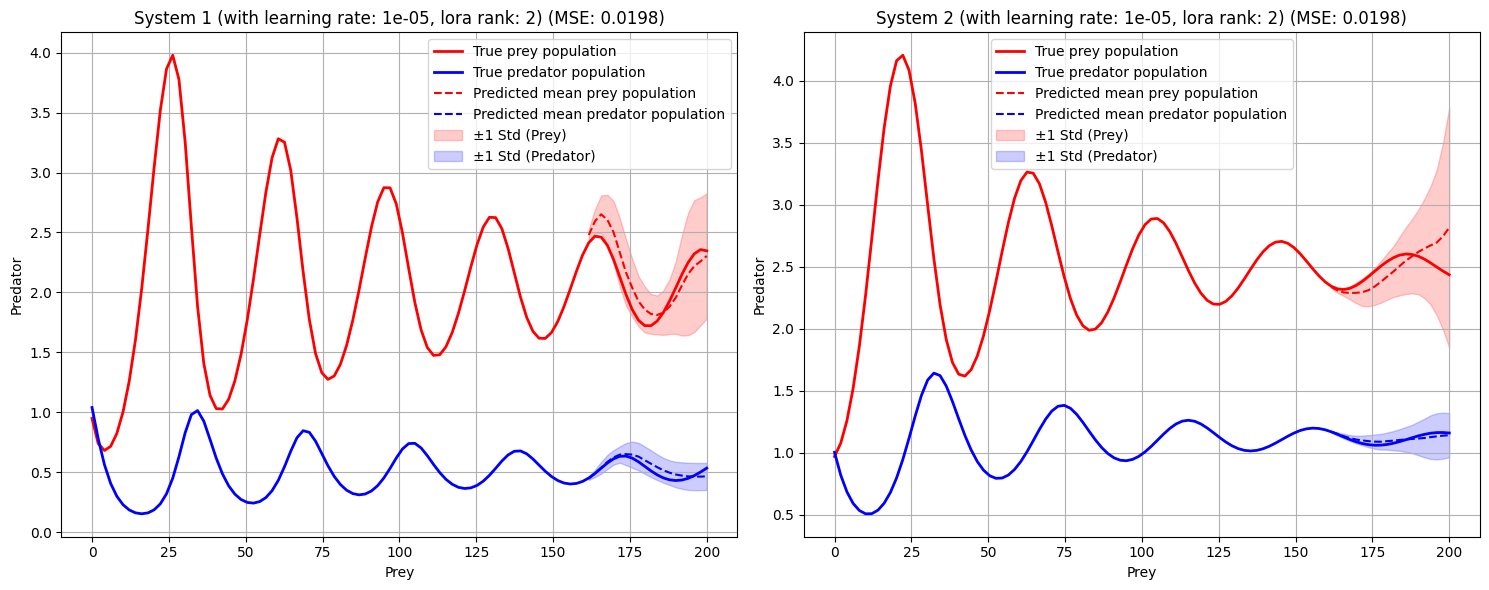


>>> Training with learning rate: 1e-05, LoRA rank: 4


Training | Current step: 0: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 1e-05, Rank: 4, Epoch 1/5 | Train Loss: 0.3582 | Val Loss: 0.2100


Training | Current step: 903: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 1e-05, Rank: 4, Epoch 2/5 | Train Loss: 0.2232 | Val Loss: 0.1945


Training | Current step: 1806: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 1e-05, Rank: 4, Epoch 3/5 | Train Loss: 0.2064 | Val Loss: 0.1825


Training | Current step: 2709: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 1e-05, Rank: 4, Epoch 4/5 | Train Loss: 0.1943 | Val Loss: 0.1741


Training | Current step: 3612: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 1e-05, Rank: 4, Epoch 5/5 | Train Loss: 0.1854 | Val Loss: 0.1679


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 18, 21, 11, 15, 13, 24, 16, 18, 26, 19, 13, 24, 20, 15, 11, 16, 13, 15, 17, 17, 26, 19, 13, 24, 21, 24, 11, 16, 13, 16, 20, 17, 26, 19, 13, 23, 17, 21, 11, 16, 13, 17, 20, 22, 26, 19, 13, 21, 16, 23, 11, 16, 13, 18, 17, 16, 26, 19, 13, 19, 17, 17, 11, 16, 13, 18, 20, 20, 26, 19, 13, 16, 22, 18, 11, 16, 13, 18, 15, 24, 26, 19, 13, 15, 16, 15, 11, 16, 13, 17, 21, 20, 26, 18, 13, 24, 19, 17, 11, 16, 13, 17, 16, 21, 26, 18, 13, 24, 18, 24, 11, 16, 13, 16, 21, 24, 26, 19, 13, 15, 16, 22, 11, 16, 13, 16, 18, 23, 26, 19, 13, 16, 17, 19, 11, 16, 13, 16, 16, 22, 26, 19, 13, 17, 24, 22, 11, 16, 13, 16, 17, 21, 26, 19, 13, 19, 24, 23, 11, 16, 13, 16, 20, 22, 26, 19, 13, 22, 16, 21, 11, 16, 13, 17, 17, 20, 26, 20, 13, 15, 17, 17, 11, 16, 13, 18, 15, 15, 26, 20, 13, 17, 19, 15, 11, 16, 13, 19, 16, 16, 26, 20, 13, 19, 15, 16, 11, 16, 13, 20, 17, 18, 26, 20, 13, 18, 24, 22, 11, 16, 13, 21, 15, 20, 26, 20, 13, 17, 22, 21, 11, 16, 13, 21, 17, 24, 26, 20, 13, 16, 15, 2

System:  50%|█████     | 1/2 [04:46<04:46, 286.25s/it]

generated tokens: [26, 20, 13, 15, 17, 16, 11, 15, 13, 24, 16, 18, 26, 20, 13, 19, 15, 22, 11, 16, 13, 15, 17, 21, 26, 20, 13, 22, 17, 23, 11, 16, 13, 16, 19, 20, 26, 20, 13, 24, 18, 21, 11, 16, 13, 17, 20, 15, 26, 20, 13, 24, 20, 15, 11, 16, 13, 18, 15, 20, 26, 20, 13, 23, 20, 24, 11, 16, 13, 18, 21, 23, 26, 20, 13, 20, 24, 19, 11, 16, 13, 19, 15, 24, 26, 20, 13, 16, 16, 21, 11, 16, 13, 18, 23, 16, 26, 19, 13, 21, 17, 24, 11, 16, 13, 18, 16, 20, 26, 19, 13, 16, 18, 22, 11, 16, 13, 17, 16, 19, 26, 18, 13, 22, 21, 16, 11, 16, 13, 15, 24, 19, 26, 18, 13, 20, 22, 17, 11, 16, 13, 15, 15, 20, 26, 18, 13, 20, 15, 15, 11, 15, 13, 24, 17, 22, 26, 18, 13, 20, 16, 15, 11, 15, 13, 23, 19, 20, 26, 18, 13, 20, 20, 18, 11, 15, 13, 23, 17, 23, 26, 18, 13, 20, 23, 19, 11, 15, 13, 23, 16, 15, 26, 18, 13, 21, 18, 16, 11, 15, 13, 22, 24, 21, 26, 18, 13, 21, 18, 21, 11, 15, 13, 22, 23, 22, 26, 18, 13, 20, 23, 24, 11, 15, 13, 22, 23, 15, 26, 18, 13, 20, 19, 21, 11, 15, 13, 22, 23, 23, 26, 18, 13, 20, 15, 2

System: 100%|██████████| 2/2 [09:32<00:00, 286.14s/it]

generated tokens: [26, 19, 13, 21, 21, 15, 11, 17, 13, 18, 19, 22, 26, 19, 13, 20, 23, 17, 11, 17, 13, 18, 16, 20, 26, 19, 13, 20, 18, 24, 11, 17, 13, 17, 21, 17, 26, 19, 13, 19, 24, 23, 11, 17, 13, 17, 18, 19, 26, 19, 13, 20, 17, 20, 11, 17, 13, 17, 15, 21, 26, 19, 13, 21, 17, 22, 11, 17, 13, 16, 23, 23, 26, 19, 13, 22, 19, 21, 11, 17, 13, 16, 22, 20, 26, 19, 13, 23, 22, 22, 11, 17, 13, 16, 21, 19, 26, 19, 13, 24, 22, 20, 11, 17, 13, 16, 21, 16, 26, 20, 13, 15, 21, 15, 11, 17, 13, 16, 20, 23, 26, 20, 13, 15, 22, 22, 11, 17, 13, 16, 21, 15, 26, 20, 13, 15, 23, 21, 11, 17, 13, 16, 21, 21, 26, 20, 13, 16, 15, 21, 11, 17, 13, 16, 22, 19, 26, 20, 13, 16, 17, 16, 11, 17, 13, 16, 23, 23, 26, 20, 13, 16, 18, 23, 11, 17, 13, 17, 15, 21, 26, 20, 13, 16, 18, 20, 11, 17, 13, 17, 17, 21, 26, 20, 13, 16, 17, 23, 11, 17, 13, 17, 19, 24, 26, 20, 13, 15, 24, 21, 11, 17, 13, 17, 22, 16, 26, 19, 13, 24, 22, 17, 11, 17, 13, 17, 24, 19, 26, 19, 13, 23, 22, 24, 11, 17, 13, 18, 17, 20, 26, 19, 13, 22, 24, 2

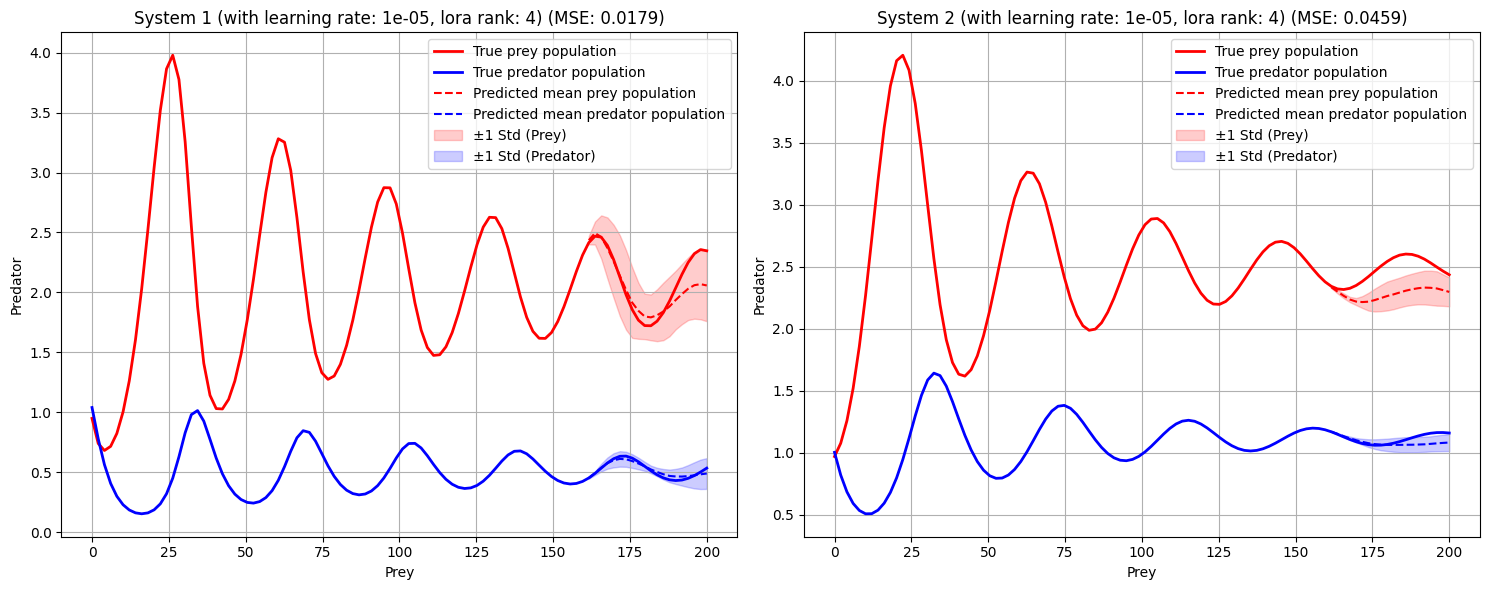


>>> Training with learning rate: 1e-05, LoRA rank: 8


Training | Current step: 0: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 1e-05, Rank: 8, Epoch 1/5 | Train Loss: 0.2984 | Val Loss: 0.2001


Training | Current step: 903: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 1e-05, Rank: 8, Epoch 2/5 | Train Loss: 0.2085 | Val Loss: 0.1810


Training | Current step: 1806: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 1e-05, Rank: 8, Epoch 3/5 | Train Loss: 0.1916 | Val Loss: 0.1703


Training | Current step: 2709: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 1e-05, Rank: 8, Epoch 4/5 | Train Loss: 0.1812 | Val Loss: 0.1630


Training | Current step: 3612: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 1e-05, Rank: 8, Epoch 5/5 | Train Loss: 0.1737 | Val Loss: 0.1576


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 18, 19, 11, 15, 13, 24, 15, 22, 26, 20, 13, 15, 15, 18, 11, 15, 13, 24, 22, 18, 26, 19, 13, 23, 17, 18, 11, 16, 13, 15, 17, 20, 26, 19, 13, 20, 17, 22, 11, 16, 13, 15, 22, 16, 26, 19, 13, 16, 21, 20, 11, 16, 13, 15, 24, 24, 26, 18, 13, 23, 22, 24, 11, 16, 13, 16, 16, 20, 26, 18, 13, 21, 16, 16, 11, 16, 13, 16, 17, 21, 26, 18, 13, 19, 15, 16, 11, 16, 13, 16, 16, 16, 26, 18, 13, 17, 24, 22, 11, 16, 13, 15, 22, 21, 26, 18, 13, 18, 17, 21, 11, 16, 13, 15, 17, 21, 26, 18, 13, 19, 19, 18, 11, 15, 13, 24, 23, 22, 26, 18, 13, 20, 19, 23, 11, 15, 13, 24, 18, 21, 26, 18, 13, 21, 19, 19, 11, 15, 13, 23, 24, 21, 26, 18, 13, 22, 17, 17, 11, 15, 13, 23, 20, 17, 26, 18, 13, 23, 15, 20, 11, 15, 13, 23, 16, 23, 26, 18, 13, 23, 22, 19, 11, 15, 13, 22, 23, 22, 26, 18, 13, 24, 19, 17, 11, 15, 13, 22, 21, 21, 26, 19, 13, 15, 15, 18, 11, 15, 13, 22, 20, 21, 26, 19, 13, 15, 19, 15, 11, 15, 13, 22, 19, 23, 26, 19, 13, 15, 21, 21, 11, 15, 13, 22, 19, 18, 26, 19, 13, 15, 24, 1

System:  50%|█████     | 1/2 [04:46<04:46, 286.05s/it]

generated tokens: [26, 19, 13, 23, 21, 20, 11, 15, 13, 24, 15, 21, 26, 19, 13, 24, 22, 20, 11, 15, 13, 24, 23, 20, 26, 19, 13, 23, 22, 17, 11, 16, 13, 15, 21, 17, 26, 19, 13, 19, 23, 15, 11, 16, 13, 16, 16, 18, 26, 18, 13, 24, 21, 17, 11, 16, 13, 16, 20, 16, 26, 18, 13, 19, 15, 19, 11, 16, 13, 16, 23, 16, 26, 18, 13, 15, 16, 18, 11, 16, 13, 16, 20, 17, 26, 17, 13, 22, 16, 21, 11, 16, 13, 15, 22, 23, 26, 17, 13, 20, 15, 19, 11, 16, 13, 15, 17, 18, 26, 17, 13, 19, 16, 18, 11, 15, 13, 24, 22, 20, 26, 17, 13, 19, 17, 20, 11, 15, 13, 24, 16, 15, 26, 17, 13, 19, 23, 17, 11, 15, 13, 23, 20, 18, 26, 17, 13, 20, 22, 24, 11, 15, 13, 23, 16, 18, 26, 17, 13, 21, 23, 22, 11, 15, 13, 22, 22, 19, 26, 17, 13, 23, 15, 24, 11, 15, 13, 22, 20, 22, 26, 17, 13, 24, 17, 16, 11, 15, 13, 22, 21, 22, 26, 18, 13, 15, 20, 20, 11, 15, 13, 23, 16, 21, 26, 18, 13, 16, 21, 24, 11, 15, 13, 23, 22, 23, 26, 18, 13, 17, 23, 16, 11, 15, 13, 24, 21, 17, 26, 18, 13, 18, 24, 16, 11, 16, 13, 15, 20, 16, 26, 18, 13, 19, 21, 2

System: 100%|██████████| 2/2 [09:32<00:00, 286.07s/it]

generated tokens: [26, 19, 13, 21, 21, 15, 11, 17, 13, 18, 19, 24, 26, 19, 13, 21, 15, 24, 11, 17, 13, 18, 17, 16, 26, 19, 13, 20, 20, 20, 11, 17, 13, 17, 24, 21, 26, 19, 13, 20, 15, 15, 11, 17, 13, 17, 22, 15, 26, 19, 13, 19, 20, 16, 11, 17, 13, 17, 20, 15, 26, 19, 13, 19, 16, 15, 11, 17, 13, 17, 17, 17, 26, 19, 13, 18, 22, 16, 11, 17, 13, 17, 15, 15, 26, 19, 13, 18, 21, 17, 11, 17, 13, 16, 23, 19, 26, 19, 13, 18, 21, 18, 11, 17, 13, 16, 21, 19, 26, 19, 13, 18, 21, 16, 11, 17, 13, 16, 19, 19, 26, 19, 13, 18, 20, 16, 11, 17, 13, 16, 17, 21, 26, 19, 13, 18, 19, 20, 11, 17, 13, 16, 16, 16, 26, 19, 13, 18, 18, 20, 11, 17, 13, 15, 24, 19, 26, 19, 13, 18, 17, 22, 11, 17, 13, 15, 22, 22, 26, 19, 13, 18, 16, 19, 11, 17, 13, 15, 21, 23, 26, 19, 13, 18, 15, 22, 11, 17, 13, 15, 21, 18, 26, 19, 13, 18, 15, 19, 11, 17, 13, 15, 20, 23, 26, 19, 13, 18, 15, 23, 11, 17, 13, 15, 20, 18, 26, 19, 13, 18, 16, 19, 11, 17, 13, 15, 20, 17, 26, 19, 13, 18, 17, 19, 11, 17, 13, 15, 20, 19, 26, 19, 13, 18, 18, 1

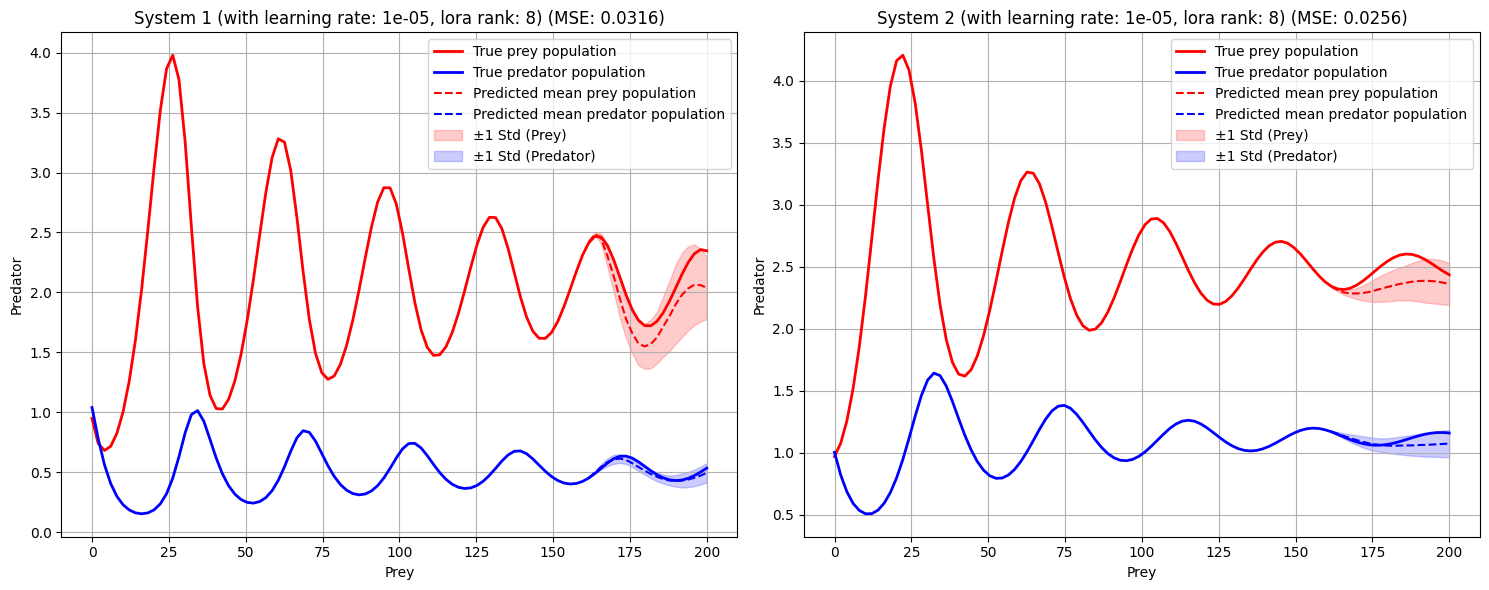


>>> Training with learning rate: 5e-05, LoRA rank: 2


Training | Current step: 0: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 5e-05, Rank: 2, Epoch 1/5 | Train Loss: 0.2667 | Val Loss: 0.1829


Training | Current step: 903: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 5e-05, Rank: 2, Epoch 2/5 | Train Loss: 0.1889 | Val Loss: 0.1653


Training | Current step: 1806: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.03it/s]


LR: 5e-05, Rank: 2, Epoch 3/5 | Train Loss: 0.1731 | Val Loss: 0.1552


Training | Current step: 2709: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 5e-05, Rank: 2, Epoch 4/5 | Train Loss: 0.1637 | Val Loss: 0.1492


Training | Current step: 3612: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  7.02it/s]


LR: 5e-05, Rank: 2, Epoch 5/5 | Train Loss: 0.1579 | Val Loss: 0.1448


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 19, 15, 11, 15, 13, 24, 15, 15, 26, 19, 13, 24, 22, 17, 11, 16, 13, 15, 15, 16, 26, 20, 13, 15, 20, 22, 11, 16, 13, 16, 17, 23, 26, 20, 13, 15, 21, 19, 11, 16, 13, 17, 22, 15, 26, 19, 13, 23, 23, 22, 11, 16, 13, 18, 22, 18, 26, 19, 13, 21, 22, 19, 11, 16, 13, 19, 18, 20, 26, 19, 13, 18, 21, 21, 11, 16, 13, 19, 18, 22, 26, 19, 13, 15, 19, 15, 11, 16, 13, 18, 24, 18, 26, 18, 13, 22, 23, 24, 11, 16, 13, 18, 15, 16, 26, 18, 13, 21, 16, 23, 11, 16, 13, 17, 15, 21, 26, 18, 13, 20, 18, 17, 11, 16, 13, 15, 24, 15, 26, 18, 13, 20, 21, 18, 11, 15, 13, 24, 22, 19, 26, 18, 13, 22, 21, 24, 11, 15, 13, 23, 23, 22, 26, 19, 13, 15, 15, 24, 11, 15, 13, 23, 17, 20, 26, 19, 13, 17, 19, 21, 11, 15, 13, 22, 23, 24, 26, 19, 13, 19, 20, 17, 11, 15, 13, 22, 23, 23, 26, 19, 13, 21, 16, 18, 11, 15, 13, 23, 15, 17, 26, 19, 13, 22, 16, 23, 11, 15, 13, 23, 18, 17, 26, 19, 13, 22, 19, 22, 11, 15, 13, 23, 23, 19, 26, 19, 13, 21, 23, 19, 11, 16, 13, 15, 15, 23, 26, 19, 13, 20, 19, 2

System:  50%|█████     | 1/2 [04:46<04:46, 286.73s/it]

generated tokens: [26, 19, 13, 23, 23, 23, 11, 15, 13, 24, 17, 22, 26, 20, 13, 16, 15, 17, 11, 16, 13, 15, 20, 22, 26, 20, 13, 17, 23, 24, 11, 16, 13, 16, 22, 21, 26, 20, 13, 19, 21, 18, 11, 16, 13, 17, 24, 23, 26, 20, 13, 20, 23, 17, 11, 16, 13, 19, 16, 15, 26, 20, 13, 20, 23, 23, 11, 16, 13, 20, 17, 19, 26, 20, 13, 19, 18, 16, 11, 16, 13, 21, 15, 20, 26, 20, 13, 15, 19, 21, 11, 16, 13, 21, 21, 18, 26, 19, 13, 20, 21, 15, 11, 16, 13, 21, 21, 18, 26, 19, 13, 15, 19, 24, 11, 16, 13, 21, 15, 20, 26, 18, 13, 21, 18, 23, 11, 16, 13, 20, 17, 15, 26, 18, 13, 17, 22, 20, 11, 16, 13, 19, 17, 20, 26, 18, 13, 15, 18, 19, 11, 16, 13, 18, 18, 19, 26, 17, 13, 24, 16, 16, 11, 16, 13, 17, 19, 20, 26, 18, 13, 15, 18, 19, 11, 16, 13, 16, 21, 16, 26, 18, 13, 17, 18, 20, 11, 16, 13, 16, 15, 19, 26, 18, 13, 20, 15, 20, 11, 16, 13, 15, 21, 15, 26, 18, 13, 23, 16, 20, 11, 16, 13, 15, 17, 20, 26, 19, 13, 16, 19, 15, 11, 16, 13, 15, 16, 17, 26, 19, 13, 19, 18, 21, 11, 16, 13, 15, 17, 15, 26, 19, 13, 22, 15, 2

System: 100%|██████████| 2/2 [09:33<00:00, 286.76s/it]

generated tokens: [26, 19, 13, 21, 23, 20, 11, 17, 13, 18, 20, 22, 26, 19, 13, 21, 17, 17, 11, 17, 13, 18, 18, 22, 26, 19, 13, 20, 21, 21, 11, 17, 13, 18, 17, 15, 26, 19, 13, 20, 18, 19, 11, 17, 13, 18, 15, 19, 26, 19, 13, 20, 17, 20, 11, 17, 13, 17, 23, 17, 26, 19, 13, 20, 20, 24, 11, 17, 13, 17, 20, 23, 26, 19, 13, 21, 16, 15, 11, 17, 13, 17, 18, 20, 26, 19, 13, 21, 21, 19, 11, 17, 13, 17, 16, 23, 26, 19, 13, 22, 16, 19, 11, 17, 13, 17, 16, 16, 26, 19, 13, 22, 21, 23, 11, 17, 13, 17, 15, 18, 26, 19, 13, 23, 17, 24, 11, 17, 13, 16, 24, 22, 26, 19, 13, 23, 23, 24, 11, 17, 13, 16, 24, 17, 26, 19, 13, 24, 20, 22, 11, 17, 13, 16, 24, 15, 26, 20, 13, 15, 17, 16, 11, 17, 13, 16, 23, 20, 26, 20, 13, 15, 23, 18, 11, 17, 13, 16, 22, 24, 26, 20, 13, 16, 17, 24, 11, 17, 13, 16, 22, 20, 26, 20, 13, 16, 20, 23, 11, 17, 13, 16, 22, 18, 26, 20, 13, 16, 21, 18, 11, 17, 13, 16, 22, 16, 26, 20, 13, 16, 21, 21, 11, 17, 13, 16, 21, 24, 26, 20, 13, 16, 22, 23, 11, 17, 13, 16, 21, 22, 26, 20, 13, 16, 24, 1

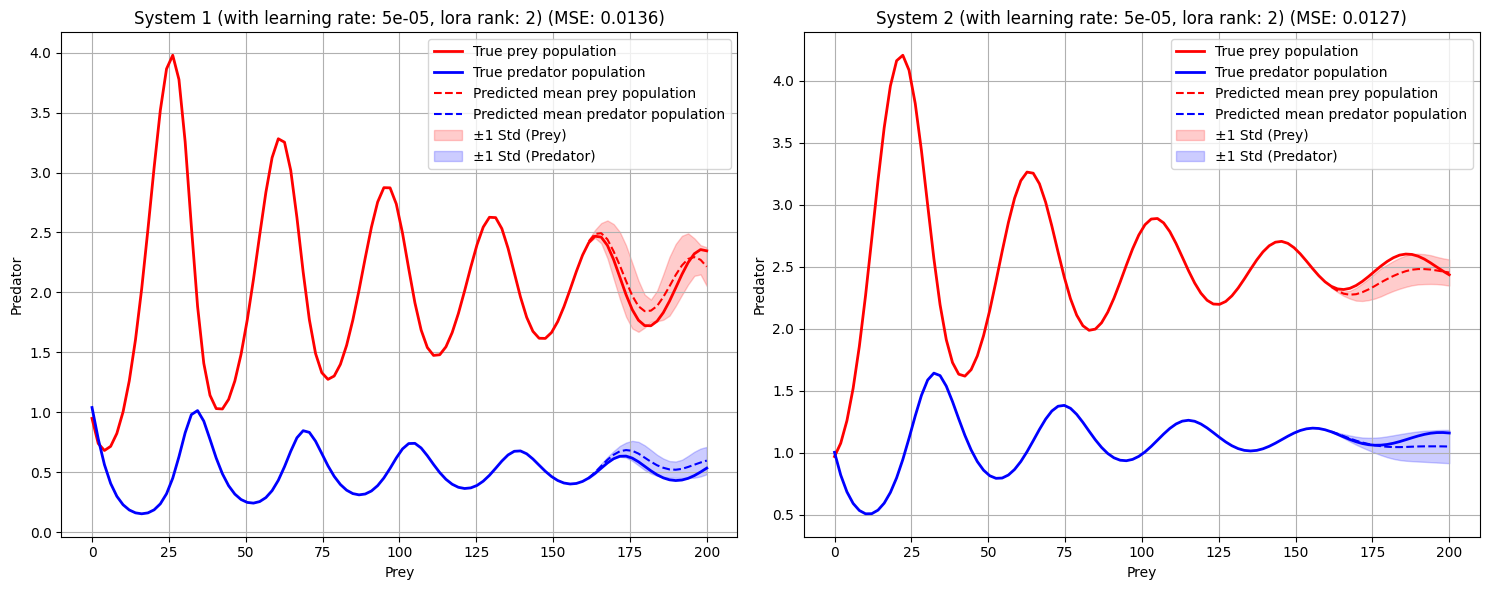


>>> Training with learning rate: 5e-05, LoRA rank: 4


Training | Current step: 0: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 5e-05, Rank: 4, Epoch 1/5 | Train Loss: 0.2426 | Val Loss: 0.1752


Training | Current step: 903: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  7.03it/s]


LR: 5e-05, Rank: 4, Epoch 2/5 | Train Loss: 0.1792 | Val Loss: 0.1577


Training | Current step: 1806: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 5e-05, Rank: 4, Epoch 3/5 | Train Loss: 0.1644 | Val Loss: 0.1488


Training | Current step: 2709: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.04it/s]


LR: 5e-05, Rank: 4, Epoch 4/5 | Train Loss: 0.1570 | Val Loss: 0.1434


Training | Current step: 3612: 100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  7.02it/s]


LR: 5e-05, Rank: 4, Epoch 5/5 | Train Loss: 0.1520 | Val Loss: 0.1399


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 15, 17, 11, 15, 13, 24, 15, 17, 26, 19, 13, 23, 23, 18, 11, 15, 13, 24, 23, 23, 26, 19, 13, 23, 18, 21, 11, 16, 13, 15, 23, 22, 26, 19, 13, 21, 24, 19, 11, 16, 13, 16, 24, 17, 26, 19, 13, 19, 24, 24, 11, 16, 13, 17, 24, 18, 26, 19, 13, 17, 22, 22, 11, 16, 13, 18, 21, 21, 26, 19, 13, 15, 19, 19, 11, 16, 13, 19, 17, 24, 26, 18, 13, 23, 20, 22, 11, 16, 13, 19, 19, 19, 26, 18, 13, 21, 22, 15, 11, 16, 13, 19, 17, 22, 26, 18, 13, 20, 16, 19, 11, 16, 13, 18, 21, 24, 26, 18, 13, 19, 16, 18, 11, 16, 13, 17, 24, 22, 26, 18, 13, 19, 17, 22, 11, 16, 13, 17, 17, 24, 26, 18, 13, 19, 24, 19, 11, 16, 13, 16, 21, 16, 26, 18, 13, 21, 16, 20, 11, 16, 13, 16, 15, 19, 26, 18, 13, 22, 20, 16, 11, 16, 13, 15, 20, 21, 26, 18, 13, 24, 15, 22, 11, 16, 13, 15, 17, 20, 26, 19, 13, 15, 20, 16, 11, 16, 13, 15, 15, 21, 26, 19, 13, 16, 21, 17, 11, 15, 13, 24, 24, 23, 26, 19, 13, 17, 19, 16, 11, 15, 13, 24, 24, 22, 26, 19, 13, 17, 24, 21, 11, 15, 13, 24, 24, 23, 26, 19, 13, 18, 18, 1

System:  50%|█████     | 1/2 [04:46<04:46, 286.19s/it]

generated tokens: [26, 19, 13, 23, 19, 24, 11, 15, 13, 24, 15, 23, 26, 19, 13, 24, 22, 19, 11, 15, 13, 24, 24, 19, 26, 19, 13, 24, 18, 18, 11, 16, 13, 15, 24, 21, 26, 19, 13, 21, 23, 18, 11, 16, 13, 16, 24, 23, 26, 19, 13, 17, 21, 22, 11, 16, 13, 17, 22, 19, 26, 18, 13, 23, 23, 15, 11, 16, 13, 18, 15, 17, 26, 18, 13, 20, 22, 15, 11, 16, 13, 17, 22, 23, 26, 18, 13, 18, 23, 22, 11, 16, 13, 17, 17, 21, 26, 18, 13, 18, 17, 16, 11, 16, 13, 16, 20, 17, 26, 18, 13, 18, 22, 17, 11, 16, 13, 15, 23, 22, 26, 18, 13, 20, 16, 19, 11, 16, 13, 15, 17, 20, 26, 18, 13, 21, 23, 23, 11, 16, 13, 15, 15, 20, 26, 18, 13, 23, 23, 23, 11, 16, 13, 15, 15, 20, 26, 19, 13, 15, 21, 22, 11, 16, 13, 15, 16, 23, 26, 19, 13, 17, 15, 15, 11, 16, 13, 15, 19, 18, 26, 19, 13, 17, 17, 21, 11, 16, 13, 15, 23, 16, 26, 19, 13, 16, 19, 16, 11, 16, 13, 16, 17, 21, 26, 18, 13, 24, 24, 17, 11, 16, 13, 16, 21, 24, 26, 18, 13, 23, 18, 21, 11, 16, 13, 17, 15, 21, 26, 18, 13, 21, 22, 22, 11, 16, 13, 17, 17, 20, 26, 18, 13, 20, 18, 2

System: 100%|██████████| 2/2 [09:32<00:00, 286.19s/it]

generated tokens: [26, 19, 13, 21, 22, 21, 11, 17, 13, 18, 19, 18, 26, 19, 13, 21, 17, 21, 11, 17, 13, 18, 16, 21, 26, 19, 13, 21, 16, 17, 11, 17, 13, 17, 23, 16, 26, 19, 13, 21, 18, 22, 11, 17, 13, 17, 19, 18, 26, 19, 13, 21, 24, 15, 11, 17, 13, 17, 15, 20, 26, 19, 13, 22, 22, 16, 11, 17, 13, 16, 22, 15, 26, 19, 13, 23, 22, 23, 11, 17, 13, 16, 18, 24, 26, 19, 13, 24, 24, 24, 11, 17, 13, 16, 15, 24, 26, 20, 13, 16, 17, 22, 11, 17, 13, 15, 23, 20, 26, 20, 13, 17, 20, 22, 11, 17, 13, 15, 21, 24, 26, 20, 13, 18, 23, 22, 11, 17, 13, 15, 21, 24, 26, 20, 13, 20, 17, 17, 11, 17, 13, 15, 23, 15, 26, 20, 13, 21, 20, 18, 11, 17, 13, 16, 15, 23, 26, 20, 13, 22, 20, 15, 11, 17, 13, 16, 19, 19, 26, 20, 13, 23, 15, 20, 11, 17, 13, 16, 24, 16, 26, 20, 13, 23, 17, 23, 11, 17, 13, 17, 18, 19, 26, 20, 13, 22, 24, 22, 11, 17, 13, 17, 22, 24, 26, 20, 13, 22, 17, 20, 11, 17, 13, 18, 17, 21, 26, 20, 13, 20, 24, 22, 11, 17, 13, 18, 21, 22, 26, 20, 13, 19, 21, 23, 11, 17, 13, 19, 15, 17, 26, 20, 13, 18, 17, 1

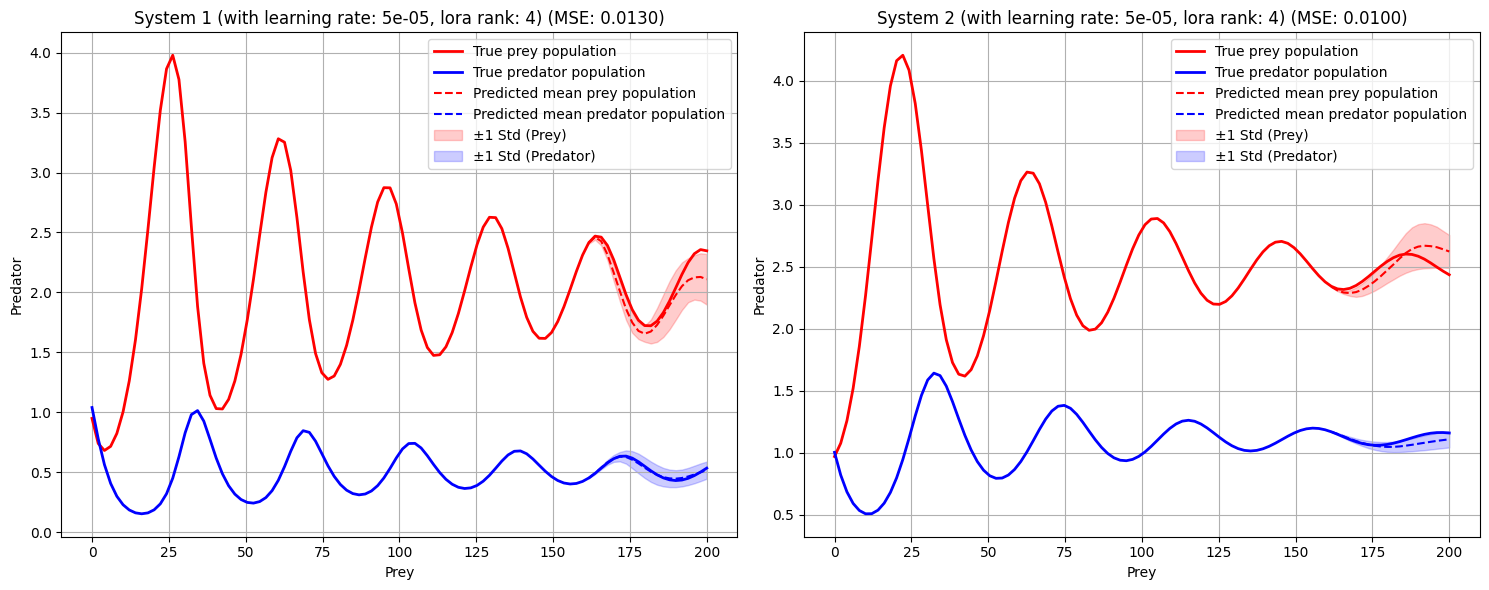


>>> Training with learning rate: 5e-05, LoRA rank: 8


Training | Current step: 0: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 5e-05, Rank: 8, Epoch 1/5 | Train Loss: 0.2181 | Val Loss: 0.1636


Training | Current step: 903: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 5e-05, Rank: 8, Epoch 2/5 | Train Loss: 0.1666 | Val Loss: 0.1493


Training | Current step: 1806: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 5e-05, Rank: 8, Epoch 3/5 | Train Loss: 0.1559 | Val Loss: 0.1419


Training | Current step: 2709: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 5e-05, Rank: 8, Epoch 4/5 | Train Loss: 0.1497 | Val Loss: 0.1384


Training | Current step: 3612: 100%|██████████| 903/903 [04:36<00:00,  3.26it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  6.98it/s]


LR: 5e-05, Rank: 8, Epoch 5/5 | Train Loss: 0.1455 | Val Loss: 0.1350


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 21, 20, 11, 15, 13, 24, 15, 21, 26, 19, 13, 24, 23, 19, 11, 15, 13, 24, 22, 24, 26, 20, 13, 15, 16, 19, 11, 16, 13, 15, 20, 22, 26, 20, 13, 15, 15, 16, 11, 16, 13, 16, 18, 15, 26, 19, 13, 23, 23, 18, 11, 16, 13, 16, 24, 24, 26, 19, 13, 22, 16, 24, 11, 16, 13, 17, 18, 15, 26, 19, 13, 20, 16, 21, 11, 16, 13, 17, 17, 15, 26, 19, 13, 18, 15, 18, 11, 16, 13, 16, 22, 15, 26, 19, 13, 16, 19, 20, 11, 16, 13, 16, 15, 17, 26, 19, 13, 15, 20, 24, 11, 16, 13, 15, 17, 22, 26, 19, 13, 15, 20, 24, 11, 15, 13, 24, 19, 22, 26, 19, 13, 16, 16, 19, 11, 15, 13, 23, 22, 20, 26, 19, 13, 17, 17, 15, 11, 15, 13, 23, 16, 19, 26, 19, 13, 18, 21, 15, 11, 15, 13, 22, 21, 20, 26, 19, 13, 20, 17, 21, 11, 15, 13, 22, 17, 21, 26, 19, 13, 21, 24, 16, 11, 15, 13, 21, 24, 20, 26, 19, 13, 23, 18, 15, 11, 15, 13, 21, 22, 19, 26, 19, 13, 24, 18, 21, 11, 15, 13, 21, 21, 20, 26, 19, 13, 24, 24, 23, 11, 15, 13, 21, 21, 20, 26, 20, 13, 15, 18, 19, 11, 15, 13, 21, 22, 16, 26, 20, 13, 15, 18, 1

System:  50%|█████     | 1/2 [04:46<04:46, 286.08s/it]

generated tokens: [26, 19, 13, 23, 17, 16, 11, 15, 13, 24, 15, 15, 26, 19, 13, 24, 17, 18, 11, 15, 13, 24, 21, 23, 26, 19, 13, 24, 20, 24, 11, 16, 13, 15, 18, 20, 26, 19, 13, 24, 16, 23, 11, 16, 13, 15, 24, 22, 26, 19, 13, 23, 16, 17, 11, 16, 13, 16, 19, 18, 26, 19, 13, 21, 22, 22, 11, 16, 13, 16, 22, 18, 26, 19, 13, 20, 18, 17, 11, 16, 13, 16, 22, 20, 26, 19, 13, 18, 24, 24, 11, 16, 13, 16, 19, 22, 26, 19, 13, 18, 15, 17, 11, 16, 13, 15, 24, 23, 26, 19, 13, 17, 20, 18, 11, 16, 13, 15, 19, 18, 26, 19, 13, 17, 20, 20, 11, 15, 13, 24, 23, 21, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 15164

System: 100%|██████████| 2/2 [09:32<00:00, 286.13s/it]

generated tokens: [26, 19, 13, 21, 22, 18, 11, 17, 13, 18, 18, 24, 26, 19, 13, 21, 16, 19, 11, 17, 13, 17, 24, 22, 26, 19, 13, 20, 23, 18, 11, 17, 13, 17, 20, 16, 26, 19, 13, 20, 24, 20, 11, 17, 13, 17, 15, 15, 26, 19, 13, 21, 19, 22, 11, 17, 13, 16, 20, 16, 26, 19, 13, 22, 17, 18, 11, 17, 13, 16, 15, 24, 26, 19, 13, 23, 16, 19, 11, 17, 13, 15, 22, 23, 26, 19, 13, 24, 15, 20, 11, 17, 13, 15, 20, 23, 26, 19, 13, 24, 24, 23, 11, 17, 13, 15, 19, 24, 26, 20, 13, 15, 22, 21, 11, 17, 13, 15, 19, 22, 26, 20, 13, 16, 17, 23, 11, 17, 13, 15, 20, 17, 26, 20, 13, 16, 21, 18, 11, 17, 13, 15, 21, 16, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 15164

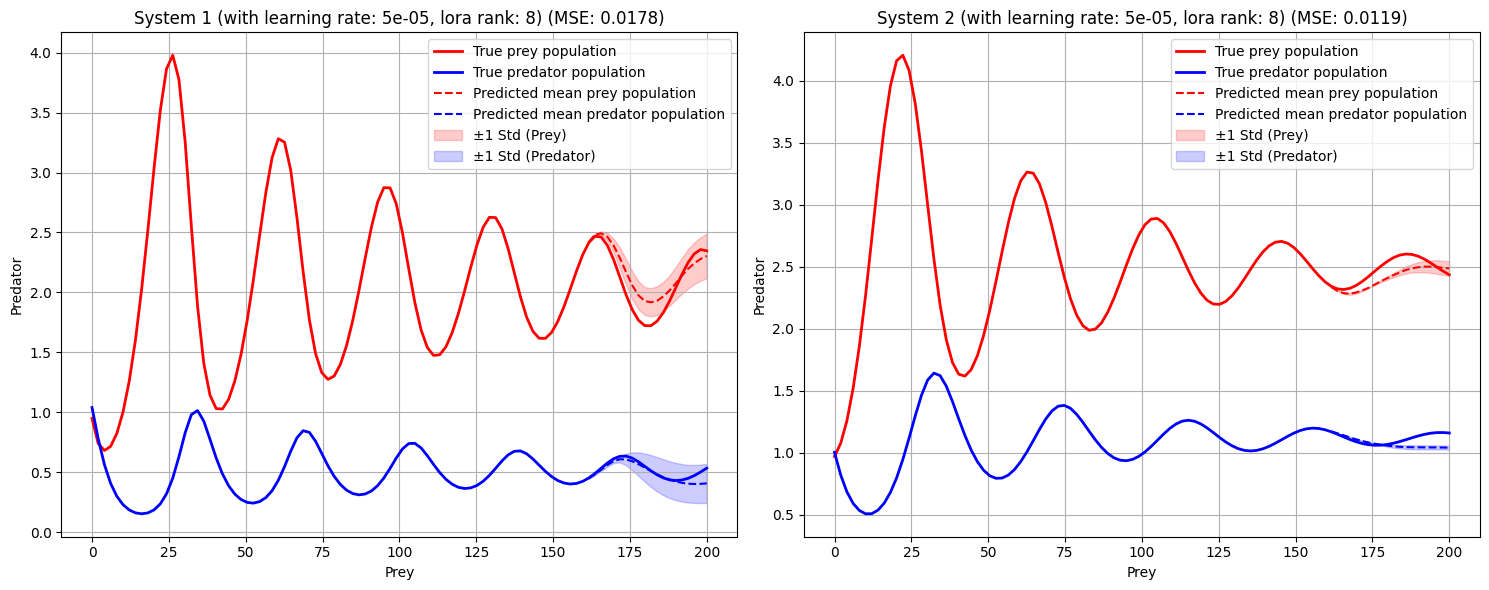


>>> Training with learning rate: 0.0001, LoRA rank: 2


Training | Current step: 0: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 0.0001, Rank: 2, Epoch 1/5 | Train Loss: 0.2291 | Val Loss: 0.1688


Training | Current step: 903: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  6.97it/s]


LR: 0.0001, Rank: 2, Epoch 2/5 | Train Loss: 0.1702 | Val Loss: 0.1512


Training | Current step: 1806: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 0.0001, Rank: 2, Epoch 3/5 | Train Loss: 0.1579 | Val Loss: 0.1439


Training | Current step: 2709: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  6.98it/s]


LR: 0.0001, Rank: 2, Epoch 4/5 | Train Loss: 0.1518 | Val Loss: 0.1399


Training | Current step: 3612: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 0.0001, Rank: 2, Epoch 5/5 | Train Loss: 0.1477 | Val Loss: 0.1363


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 19, 16, 11, 15, 13, 23, 24, 21, 26, 19, 13, 24, 19, 18, 11, 15, 13, 24, 20, 15, 26, 19, 13, 23, 24, 22, 11, 16, 13, 15, 17, 20, 26, 19, 13, 22, 17, 21, 11, 16, 13, 15, 24, 20, 26, 19, 13, 19, 15, 23, 11, 16, 13, 16, 17, 24, 26, 19, 13, 15, 21, 15, 11, 16, 13, 16, 16, 23, 26, 18, 13, 22, 16, 23, 11, 16, 13, 15, 20, 23, 26, 18, 13, 19, 20, 23, 11, 16, 13, 15, 15, 16, 26, 18, 13, 18, 19, 21, 11, 15, 13, 24, 18, 17, 26, 18, 13, 18, 18, 18, 11, 15, 13, 23, 20, 24, 26, 18, 13, 18, 24, 22, 11, 15, 13, 22, 24, 18, 26, 18, 13, 20, 15, 20, 11, 15, 13, 22, 19, 18, 26, 18, 13, 21, 19, 21, 11, 15, 13, 22, 15, 15, 26, 18, 13, 23, 15, 17, 11, 15, 13, 21, 22, 16, 26, 19, 13, 15, 16, 19, 11, 15, 13, 21, 20, 16, 26, 19, 13, 16, 24, 21, 11, 15, 13, 21, 19, 16, 26, 19, 13, 18, 20, 15, 11, 15, 13, 21, 19, 19, 26, 19, 13, 19, 21, 17, 11, 15, 13, 21, 20, 23, 26, 19, 13, 20, 19, 20, 11, 15, 13, 21, 23, 16, 26, 19, 13, 20, 21, 15, 11, 15, 13, 22, 17, 15, 26, 19, 13, 20, 15, 1

System:  50%|█████     | 1/2 [04:46<04:46, 286.67s/it]

generated tokens: [26, 19, 13, 23, 18, 20, 11, 15, 13, 24, 15, 22, 26, 19, 13, 24, 17, 18, 11, 15, 13, 24, 24, 23, 26, 19, 13, 23, 21, 19, 11, 16, 13, 16, 15, 15, 26, 19, 13, 21, 21, 24, 11, 16, 13, 16, 24, 16, 26, 19, 13, 18, 20, 24, 11, 16, 13, 17, 18, 18, 26, 19, 13, 15, 17, 16, 11, 16, 13, 17, 17, 24, 26, 18, 13, 22, 15, 22, 11, 16, 13, 16, 23, 15, 26, 18, 13, 19, 23, 20, 11, 16, 13, 16, 15, 19, 26, 18, 13, 18, 22, 16, 11, 16, 13, 15, 17, 24, 26, 18, 13, 18, 18, 18, 11, 15, 13, 24, 19, 19, 26, 18, 13, 18, 21, 17, 11, 15, 13, 23, 21, 19, 26, 18, 13, 19, 18, 15, 11, 15, 13, 23, 15, 22, 26, 18, 13, 20, 18, 24, 11, 15, 13, 22, 20, 21, 26, 18, 13, 21, 21, 16, 11, 15, 13, 22, 16, 24, 26, 18, 13, 22, 23, 16, 11, 15, 13, 21, 24, 16, 26, 18, 13, 24, 15, 15, 11, 15, 13, 21, 22, 17, 26, 19, 13, 15, 17, 15, 11, 15, 13, 21, 21, 17, 26, 19, 13, 16, 18, 20, 11, 15, 13, 21, 20, 18, 26, 19, 13, 17, 18, 23, 11, 15, 13, 21, 19, 22, 26, 19, 13, 18, 18, 19, 11, 15, 13, 21, 19, 19, 26, 19, 13, 19, 17, 1

System: 100%|██████████| 2/2 [09:33<00:00, 286.73s/it]

generated tokens: [26, 19, 13, 21, 22, 23, 11, 17, 13, 18, 19, 23, 26, 19, 13, 21, 15, 18, 11, 17, 13, 18, 16, 18, 26, 19, 13, 20, 20, 21, 11, 17, 13, 17, 22, 18, 26, 19, 13, 20, 18, 17, 11, 17, 13, 17, 18, 23, 26, 19, 13, 20, 18, 16, 11, 17, 13, 17, 15, 20, 26, 19, 13, 20, 20, 19, 11, 17, 13, 16, 22, 18, 26, 19, 13, 20, 24, 17, 11, 17, 13, 16, 19, 22, 26, 19, 13, 21, 19, 21, 11, 17, 13, 16, 17, 18, 26, 19, 13, 22, 15, 18, 11, 17, 13, 16, 15, 16, 26, 19, 13, 22, 20, 19, 11, 17, 13, 15, 23, 21, 26, 19, 13, 23, 16, 18, 11, 17, 13, 15, 22, 15, 26, 19, 13, 23, 20, 22, 11, 17, 13, 15, 21, 16, 26, 19, 13, 23, 24, 15, 11, 17, 13, 15, 20, 20, 26, 19, 13, 24, 17, 23, 11, 17, 13, 15, 19, 24, 26, 19, 13, 24, 20, 22, 11, 17, 13, 15, 19, 21, 26, 19, 13, 24, 23, 19, 11, 17, 13, 15, 19, 18, 26, 20, 13, 15, 15, 24, 11, 17, 13, 15, 19, 15, 26, 20, 13, 15, 17, 24, 11, 17, 13, 15, 18, 22, 26, 20, 13, 15, 20, 18, 11, 17, 13, 15, 18, 20, 26, 20, 13, 15, 22, 19, 11, 17, 13, 15, 18, 20, 26, 20, 13, 15, 24, 1

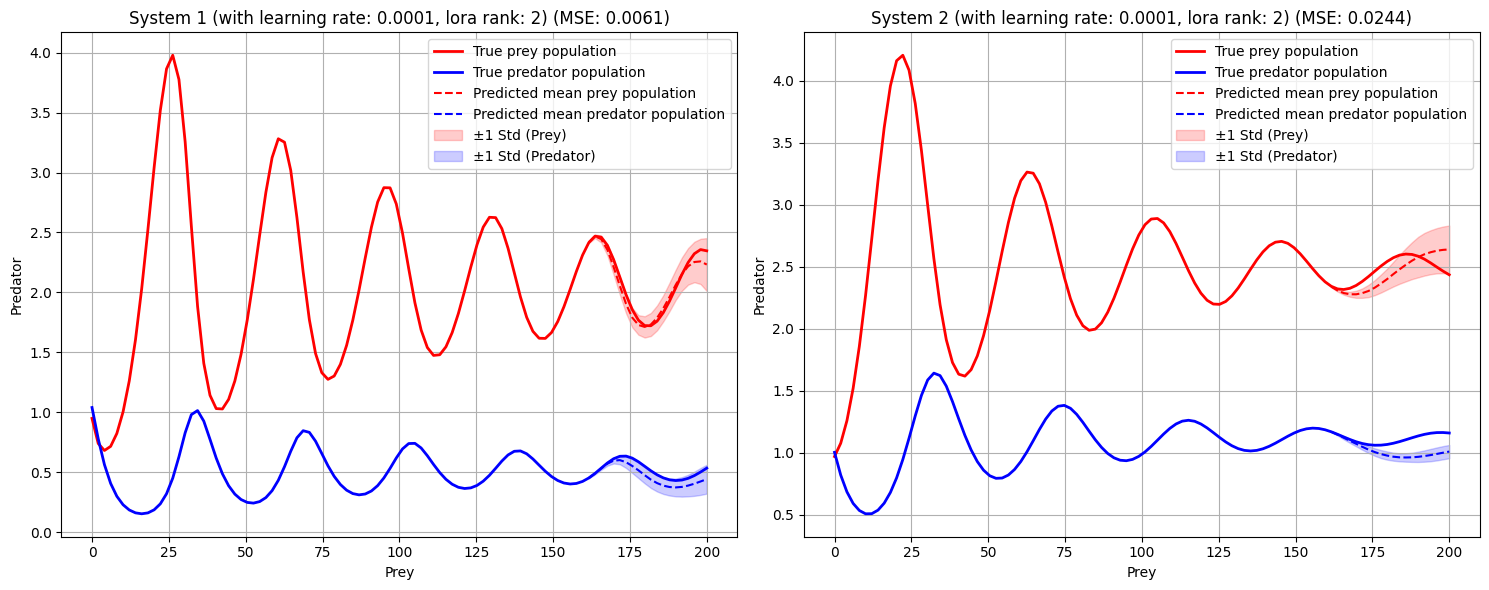


>>> Training with learning rate: 0.0001, LoRA rank: 4


Training | Current step: 0: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  6.98it/s]


LR: 0.0001, Rank: 4, Epoch 1/5 | Train Loss: 0.2112 | Val Loss: 0.1568


Training | Current step: 903: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 0.0001, Rank: 4, Epoch 2/5 | Train Loss: 0.1606 | Val Loss: 0.1445


Training | Current step: 1806: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  6.98it/s]


LR: 0.0001, Rank: 4, Epoch 3/5 | Train Loss: 0.1512 | Val Loss: 0.1389


Training | Current step: 2709: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  6.99it/s]


LR: 0.0001, Rank: 4, Epoch 4/5 | Train Loss: 0.1458 | Val Loss: 0.1341


Training | Current step: 3612: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  6.97it/s]


LR: 0.0001, Rank: 4, Epoch 5/5 | Train Loss: 0.1421 | Val Loss: 0.1312


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 18, 16, 11, 15, 13, 24, 16, 16, 26, 19, 13, 24, 17, 17, 11, 15, 13, 24, 23, 23, 26, 19, 13, 23, 20, 20, 11, 16, 13, 15, 22, 17, 26, 19, 13, 21, 23, 16, 11, 16, 13, 16, 20, 19, 26, 19, 13, 19, 18, 16, 11, 16, 13, 17, 17, 18, 26, 19, 13, 16, 21, 15, 11, 16, 13, 17, 20, 17, 26, 18, 13, 24, 18, 19, 11, 16, 13, 17, 20, 18, 26, 18, 13, 22, 19, 24, 11, 16, 13, 17, 17, 21, 26, 18, 13, 21, 19, 17, 11, 16, 13, 16, 22, 22, 26, 18, 13, 21, 15, 20, 11, 16, 13, 16, 16, 21, 26, 18, 13, 21, 19, 17, 11, 16, 13, 15, 20, 16, 26, 18, 13, 22, 17, 22, 11, 15, 13, 24, 24, 17, 26, 18, 13, 23, 20, 16, 11, 15, 13, 24, 19, 16, 26, 18, 13, 24, 24, 18, 11, 15, 13, 24, 15, 15, 26, 19, 13, 16, 18, 23, 11, 15, 13, 23, 21, 19, 26, 19, 13, 17, 23, 19, 11, 15, 13, 23, 18, 16, 26, 19, 13, 19, 17, 18, 11, 15, 13, 23, 15, 24, 26, 19, 13, 20, 19, 17, 11, 15, 13, 22, 24, 20, 26, 19, 13, 21, 18, 21, 11, 15, 13, 22, 23, 22, 26, 19, 13, 21, 24, 18, 11, 15, 13, 22, 23, 16, 26, 19, 13, 22, 18, 1

System:  50%|█████     | 1/2 [04:46<04:46, 286.31s/it]

generated tokens: [26, 19, 13, 23, 16, 18, 11, 15, 13, 24, 15, 22, 26, 19, 13, 23, 24, 24, 11, 15, 13, 24, 22, 22, 26, 19, 13, 23, 18, 23, 11, 16, 13, 15, 20, 22, 26, 19, 13, 21, 21, 21, 11, 16, 13, 16, 17, 23, 26, 19, 13, 19, 20, 19, 11, 16, 13, 16, 21, 21, 26, 19, 13, 17, 18, 15, 11, 16, 13, 16, 21, 19, 26, 19, 13, 15, 15, 23, 11, 16, 13, 16, 17, 21, 26, 18, 13, 23, 16, 24, 11, 16, 13, 15, 19, 17, 26, 18, 13, 22, 15, 15, 11, 15, 13, 24, 20, 24, 26, 18, 13, 21, 21, 16, 11, 15, 13, 23, 22, 23, 26, 18, 13, 21, 24, 18, 11, 15, 13, 23, 15, 20, 26, 18, 13, 22, 22, 22, 11, 15, 13, 22, 18, 21, 26, 18, 13, 24, 15, 16, 11, 15, 13, 21, 22, 20, 26, 19, 13, 15, 21, 21, 11, 15, 13, 21, 17, 23, 26, 19, 13, 17, 19, 16, 11, 15, 13, 20, 23, 24, 26, 19, 13, 19, 16, 17, 11, 15, 13, 20, 21, 16, 26, 19, 13, 20, 20, 20, 11, 15, 13, 20, 19, 17, 26, 19, 13, 21, 21, 24, 11, 15, 13, 20, 18, 16, 26, 19, 13, 22, 20, 22, 11, 15, 13, 20, 17, 21, 26, 19, 13, 23, 16, 16, 11, 15, 13, 20, 17, 19, 26, 19, 13, 23, 18, 1

System: 100%|██████████| 2/2 [09:32<00:00, 286.30s/it]

generated tokens: [26, 19, 13, 21, 23, 16, 11, 17, 13, 18, 19, 15, 26, 19, 13, 21, 17, 24, 11, 17, 13, 17, 24, 21, 26, 19, 13, 21, 15, 19, 11, 17, 13, 17, 19, 23, 26, 19, 13, 21, 15, 23, 11, 17, 13, 16, 24, 22, 26, 19, 13, 21, 18, 19, 11, 17, 13, 16, 19, 24, 26, 19, 13, 21, 22, 24, 11, 17, 13, 16, 15, 18, 26, 19, 13, 22, 18, 22, 11, 17, 13, 15, 21, 24, 26, 19, 13, 23, 15, 21, 11, 17, 13, 15, 18, 23, 26, 19, 13, 23, 22, 16, 11, 17, 13, 15, 15, 19, 26, 19, 13, 24, 19, 23, 11, 16, 13, 24, 22, 15, 26, 20, 13, 15, 18, 21, 11, 16, 13, 24, 18, 20, 26, 20, 13, 16, 17, 21, 11, 16, 13, 24, 15, 22, 26, 20, 13, 17, 17, 16, 11, 16, 13, 23, 23, 17, 26, 20, 13, 18, 16, 19, 11, 16, 13, 23, 21, 18, 26, 20, 13, 19, 15, 19, 11, 16, 13, 23, 20, 19, 26, 20, 13, 19, 22, 16, 11, 16, 13, 23, 20, 18, 26, 20, 13, 20, 17, 23, 11, 16, 13, 23, 21, 15, 26, 20, 13, 20, 21, 20, 11, 16, 13, 23, 21, 24, 26, 20, 13, 20, 23, 18, 11, 16, 13, 23, 23, 17, 26, 20, 13, 20, 24, 17, 11, 16, 13, 23, 24, 20, 26, 20, 13, 21, 15, 1

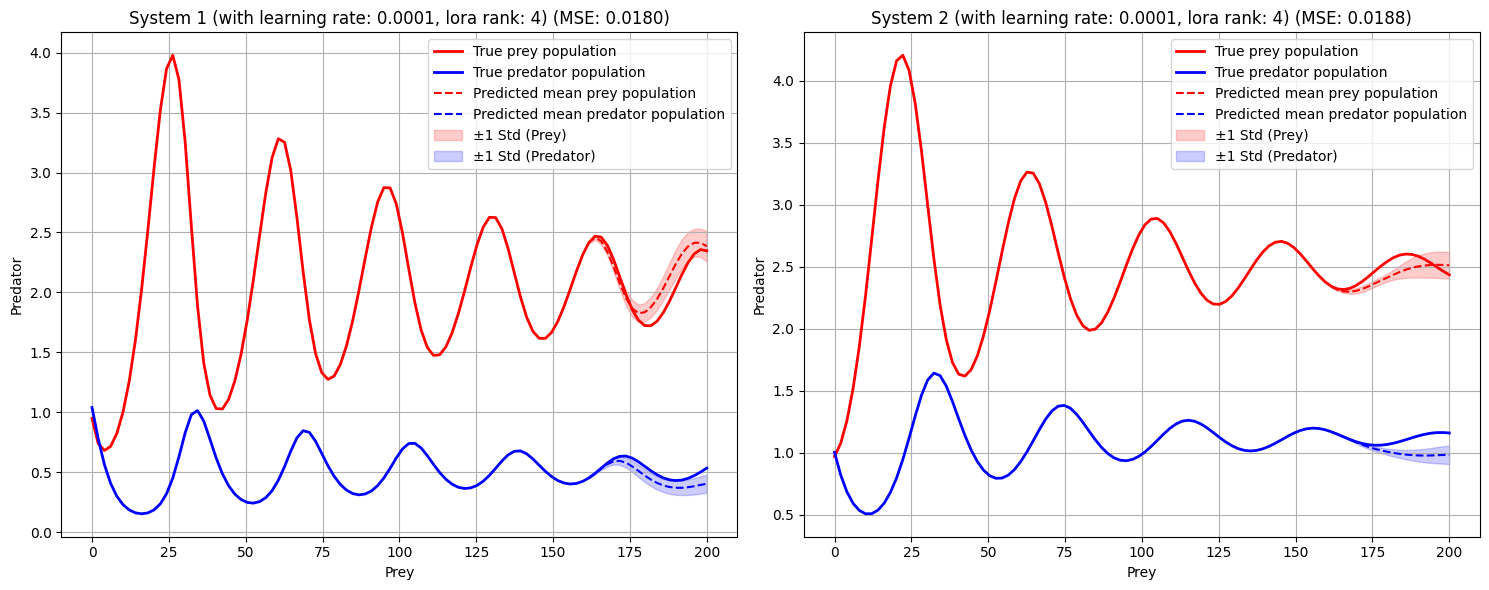


>>> Training with learning rate: 0.0001, LoRA rank: 8


Training | Current step: 0: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 903: 100%|██████████| 135/135 [00:19<00:00,  7.00it/s]


LR: 0.0001, Rank: 8, Epoch 1/5 | Train Loss: 0.1995 | Val Loss: 0.1513


Training | Current step: 903: 100%|██████████| 903/903 [04:37<00:00,  3.25it/s]
Validating | Current step 1806: 100%|██████████| 135/135 [00:19<00:00,  6.98it/s]


LR: 0.0001, Rank: 8, Epoch 2/5 | Train Loss: 0.1559 | Val Loss: 0.1407


Training | Current step: 1806: 100%|██████████| 903/903 [04:37<00:00,  3.25it/s]
Validating | Current step 2709: 100%|██████████| 135/135 [00:19<00:00,  7.03it/s]


LR: 0.0001, Rank: 8, Epoch 3/5 | Train Loss: 0.1473 | Val Loss: 0.1344


Training | Current step: 2709: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 3612: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 0.0001, Rank: 8, Epoch 4/5 | Train Loss: 0.1420 | Val Loss: 0.1308


Training | Current step: 3612: 100%|██████████| 903/903 [04:37<00:00,  3.26it/s]
Validating | Current step 4515: 100%|██████████| 135/135 [00:19<00:00,  7.01it/s]


LR: 0.0001, Rank: 8, Epoch 5/5 | Train Loss: 0.1385 | Val Loss: 0.1281


System:   0%|          | 0/2 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 23, 20, 18, 11, 15, 13, 24, 15, 19, 26, 19, 13, 24, 23, 24, 11, 15, 13, 24, 22, 24, 26, 20, 13, 15, 18, 16, 11, 16, 13, 15, 21, 22, 26, 19, 13, 24, 24, 22, 11, 16, 13, 16, 20, 24, 26, 19, 13, 23, 23, 15, 11, 16, 13, 17, 19, 16, 26, 19, 13, 21, 20, 21, 11, 16, 13, 18, 15, 19, 26, 19, 13, 18, 24, 15, 11, 16, 13, 18, 18, 15, 26, 19, 13, 16, 17, 24, 11, 16, 13, 18, 18, 17, 26, 18, 13, 24, 16, 23, 11, 16, 13, 18, 16, 15, 26, 18, 13, 22, 20, 19, 11, 16, 13, 17, 23, 15, 26, 18, 13, 21, 20, 16, 11, 16, 13, 17, 18, 17, 26, 18, 13, 21, 16, 24, 11, 16, 13, 16, 23, 17, 26, 18, 13, 21, 20, 17, 11, 16, 13, 16, 18, 24, 26, 18, 13, 22, 20, 20, 11, 16, 13, 16, 16, 17, 26, 18, 13, 24, 15, 21, 11, 16, 13, 15, 24, 22, 26, 19, 13, 15, 22, 19, 11, 16, 13, 15, 24, 21, 26, 19, 13, 17, 17, 23, 11, 16, 13, 16, 16, 17, 26, 19, 13, 18, 20, 16, 11, 16, 13, 16, 18, 22, 26, 19, 13, 18, 24, 20, 11, 16, 13, 16, 21, 22, 26, 19, 13, 18, 21, 15, 11, 16, 13, 16, 24, 22, 26, 19, 13, 18, 15, 2

System:  50%|█████     | 1/2 [04:46<04:46, 286.12s/it]

generated tokens: [26, 19, 13, 23, 18, 22, 11, 15, 13, 24, 15, 18, 26, 19, 13, 24, 18, 17, 11, 15, 13, 24, 22, 16, 26, 19, 13, 23, 24, 23, 11, 16, 13, 15, 19, 20, 26, 19, 13, 22, 21, 17, 11, 16, 13, 16, 15, 15, 26, 19, 13, 20, 18, 23, 11, 16, 13, 16, 18, 17, 26, 19, 13, 17, 24, 15, 11, 16, 13, 16, 18, 16, 26, 19, 13, 15, 21, 18, 11, 16, 13, 16, 15, 17, 26, 18, 13, 23, 24, 20, 11, 16, 13, 15, 19, 15, 26, 18, 13, 22, 24, 21, 11, 15, 13, 24, 21, 18, 26, 18, 13, 22, 21, 16, 11, 15, 13, 23, 22, 15, 26, 18, 13, 23, 15, 24, 11, 15, 13, 22, 23, 17, 26, 18, 13, 24, 15, 23, 11, 15, 13, 22, 15, 18, 26, 19, 13, 15, 19, 16, 11, 15, 13, 21, 18, 18, 26, 19, 13, 16, 24, 23, 11, 15, 13, 20, 22, 20, 26, 19, 13, 18, 21, 15, 11, 15, 13, 20, 17, 20, 26, 19, 13, 20, 16, 23, 11, 15, 13, 19, 23, 20, 26, 19, 13, 21, 19, 18, 11, 15, 13, 19, 20, 16, 26, 19, 13, 22, 19, 17, 11, 15, 13, 19, 17, 17, 26, 19, 13, 23, 15, 20, 11, 15, 13, 18, 24, 23, 26, 19, 13, 23, 21, 19, 11, 15, 13, 18, 23, 15, 26, 19, 13, 24, 15, 2

System: 100%|██████████| 2/2 [09:32<00:00, 286.18s/it]

generated tokens: [26, 19, 13, 21, 24, 21, 11, 17, 13, 18, 19, 19, 26, 19, 13, 21, 21, 24, 11, 17, 13, 18, 15, 20, 26, 19, 13, 21, 22, 18, 11, 17, 13, 17, 21, 20, 26, 19, 13, 22, 15, 17, 11, 17, 13, 17, 17, 17, 26, 19, 13, 22, 20, 15, 11, 17, 13, 16, 23, 16, 26, 19, 13, 23, 16, 24, 11, 17, 13, 16, 19, 16, 26, 19, 13, 23, 23, 21, 11, 17, 13, 16, 15, 22, 26, 19, 13, 24, 20, 18, 11, 17, 13, 15, 23, 17, 26, 20, 13, 15, 16, 23, 11, 17, 13, 15, 21, 16, 26, 20, 13, 15, 22, 16, 11, 17, 13, 15, 19, 21, 26, 20, 13, 16, 16, 21, 11, 17, 13, 15, 18, 20, 26, 20, 13, 16, 19, 23, 11, 17, 13, 15, 17, 22, 26, 20, 13, 16, 23, 16, 11, 17, 13, 15, 17, 16, 26, 20, 13, 17, 15, 21, 11, 17, 13, 15, 16, 21, 26, 20, 13, 17, 17, 20, 11, 17, 13, 15, 16, 16, 26, 20, 13, 17, 18, 24, 11, 17, 13, 15, 15, 21, 26, 20, 13, 17, 20, 18, 11, 17, 13, 15, 15, 18, 26, 20, 13, 17, 21, 18, 11, 17, 13, 15, 15, 16, 26, 20, 13, 17, 22, 17, 11, 17, 13, 15, 15, 15, 26, 20, 13, 17, 22, 24, 11, 17, 13, 15, 15, 15, 26, 20, 13, 17, 23, 1

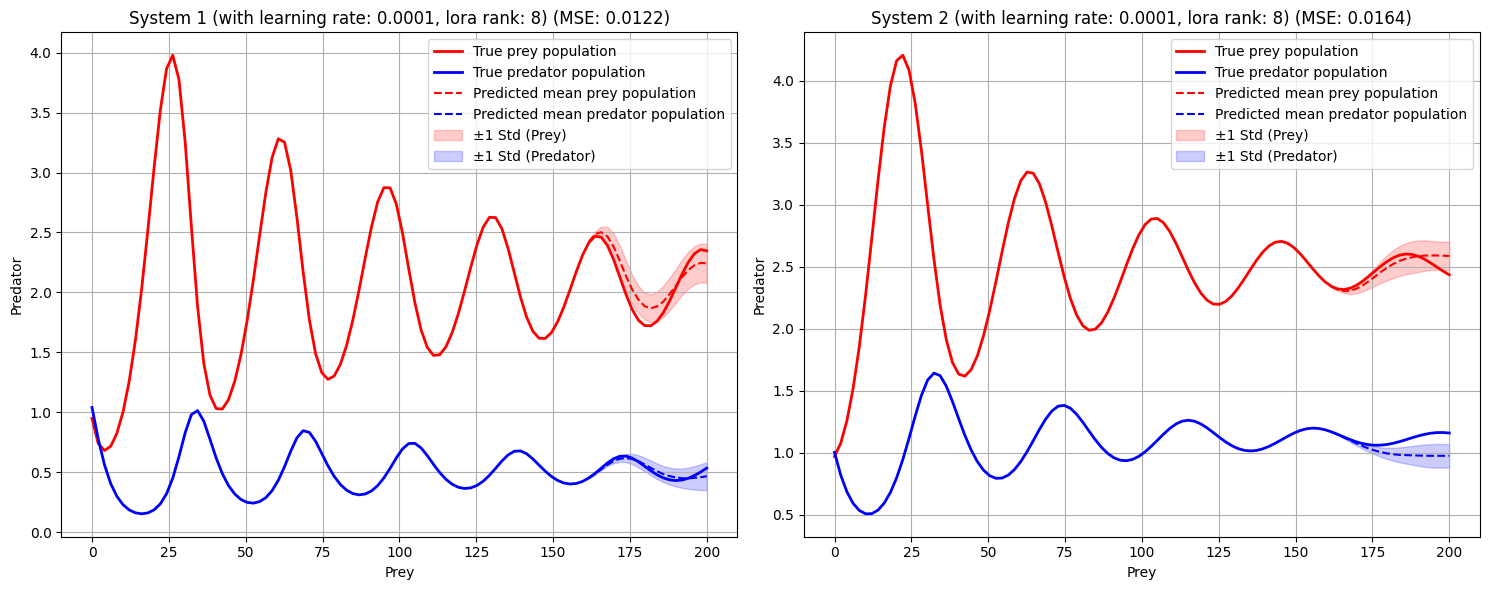

In [9]:
# Process the data into sequences of text
train_texts, val_texts, test_texts = preprocess_all_time_series(trajectories)

# Define hyperparameter configurations
learning_rates = [1e-5, 5e-5, 1e-4]
lora_ranks = [2, 4, 8]

all_train_losses = {}
all_val_losses = {}
results = []

# Grid search
for lr, rank in itertools.product(learning_rates, lora_ranks):
    print(f"\n>>> Training with learning rate: {lr}, LoRA rank: {rank}")

    # Load model
    model, tokenizer = load_qwen()

    train_losses, val_losses = train_model(model, tokenizer, train_texts, val_texts, lr, rank)

    # Store losses for plotting
    all_train_losses[(lr, rank)] = train_losses
    all_val_losses[(lr, rank)] = val_losses

    # Store final losses for table
    results.append((lr, rank, train_losses[-1], val_losses[-1]))

    # Plot predictions for the first 2 systems
    plot_predictions(model, tokenizer, lr, rank)

## Plotting the loss curves

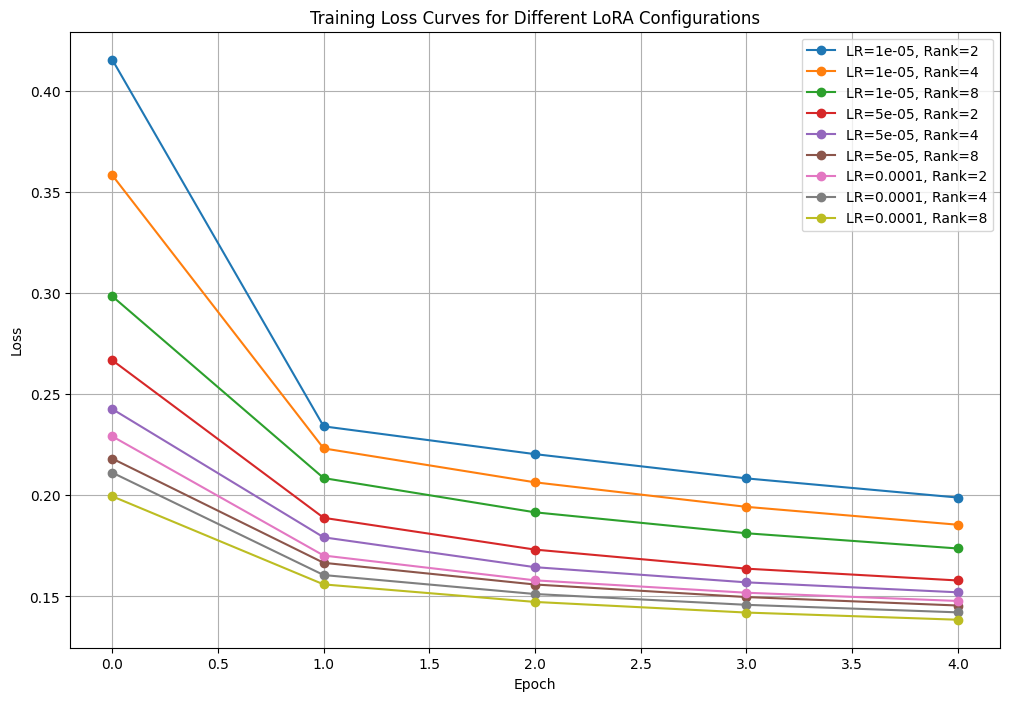

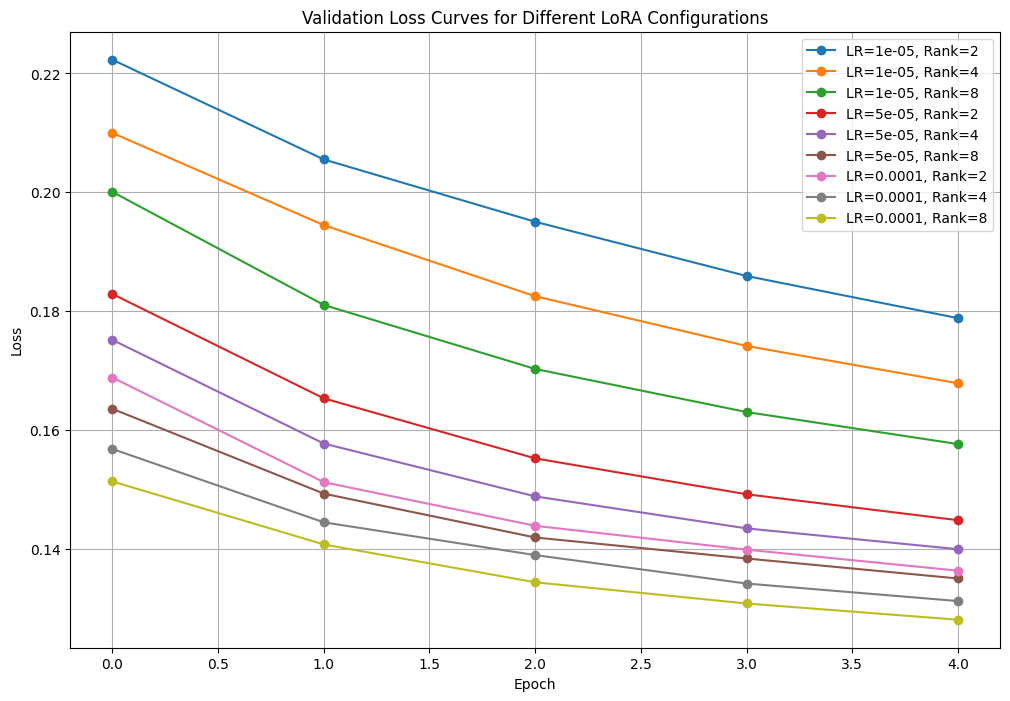

In [10]:
# Plot training loss
plt.figure(figsize=(12, 8))
for (lr, rank), losses in all_train_losses.items():
    label = f"LR={lr}, Rank={rank}"
    plt.plot(losses, marker='o', label=label)
plt.title("Training Loss Curves for Different LoRA Configurations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(12, 8))
for (lr, rank), losses in all_val_losses.items():
    label = f"LR={lr}, Rank={rank}"
    plt.plot(losses, marker='o', label=label)
plt.title("Validation Loss Curves for Different LoRA Configurations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Results Table

In [11]:
df = pd.DataFrame(
    results,
    columns=["Learning Rate", "LoRA Rank", "Final Training Loss", "Final Validation Loss"]
)

df = df.sort_values(by="Final Validation Loss")
print(df)


   Learning Rate  LoRA Rank  Final Training Loss  Final Validation Loss
8        0.00010          8             0.138472               0.128060
7        0.00010          4             0.142115               0.131203
5        0.00005          8             0.145497               0.135002
6        0.00010          2             0.147744               0.136313
4        0.00005          4             0.152022               0.139927
3        0.00005          2             0.157881               0.144813
2        0.00001          8             0.173696               0.157625
1        0.00001          4             0.185437               0.167862
0        0.00001          2             0.198879               0.178819


# Context length search